### Simple Processing
To have a benchmark of the predictive model, we can use a simple processing that uses a Bag of Words and their counting like it was proposed by  (Pang et al, 2002). 

The functions called from the module pipe can be found on the folder `0-Scripts/libs/pipeline.py`

In [44]:
%matplotlib inline
import libs.files as fh
import libs.pipeline as pipe
import libs.parse as p
import libs.twokenize as ark
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn import model_selection, feature_selection
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2
from sklearn import preprocessing as pp
from sklearn.naive_bayes import MultinomialNB

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

import re
from time import time
from collections import Counter

In [45]:
import matplotlib.pyplot as plt
# print plt.style.available
plt.style.use('ggplot')

First, read the information using the helper methods created above

In [46]:
OUTPUT_DIR = '../3-Output/'
MODEL_OUT_DIR = '../6-Models'

# read the config file
cfg = fh.read_config_file("all.yaml")

# read the train file
file_name = "../1-Input/trainingData-B.tsv"
file_type = 'B'
train_feat, labels, train_tweets = pipe.create_features(file_name, file_type, cfg)

# read the dev file
file_name = "../1-Input/devData-B.tsv"
file_type = 'B'
dev_feat, dev_labels, dev_tweets = pipe.create_features(file_name, file_type, cfg)

# read the test file
file_name = "../1-Input/testData-B.tsv"
file_type = 'B'
test_feat, gold, test_tweets = pipe.create_features(file_name, file_type, cfg)

Read 9683 rows from ../1-Input/trainingData-B.tsv
Read 1653 rows from ../1-Input/devData-B.tsv
Read 3812 rows from ../1-Input/testData-B.tsv


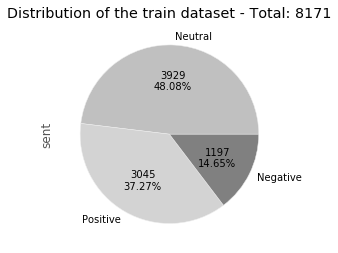

In [47]:
def print_db_stats(labels, db_name):
    """
    Print some db related stats like total tweets and polarity proportion
    """
    plt.figure()
    df = pd.DataFrame(labels, columns=['sent'])
    df.ix[df.sent==0, 'sent'] = 'Neutral'
    df.ix[df.sent==1, 'sent'] = 'Positive'
    df.ix[df.sent==-1, 'sent'] = 'Negative'
    total = df.shape[0]
    colors = ['silver', 'lightgrey', 'grey' ]
    a = df['sent'].value_counts().plot(kind='pie', figsize= (4,4),
                                       autopct=lambda(p): '{:.0f}\n{:.2f}%'.format(p * total / 100, p),
                                       colors=colors)
    a.set_title('Distribution of the {} dataset - Total: {}'.format(db_name, total))
print_db_stats(labels, 'train')

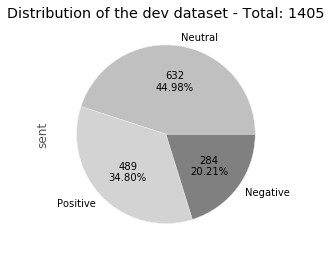

In [48]:
print_db_stats(dev_labels, 'dev')

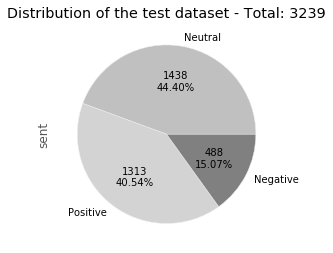

In [49]:
print_db_stats(gold, 'test')

To understand what is happening, some lines will be used as example.

In [50]:
# some random tweets
ids = [69, 78, 7, 0]
rnd_data = np.array(train_tweets)[ids]
rnd_labels = np.array(labels)[ids]
rnd_sid = np.array([ tw.sid for tw in train_feat])[ids]
for id, d, l in zip(rnd_sid, rnd_data, rnd_labels):
    print 'id:{} | sentiment:{} | text:{}'.format(id,l,d)

id:264088457490604032 | sentiment:-1 | text:"@PaperChasinAL: Damn next Saturday tho" Niggas was trynna get shit over with #early
id:264187448853151744 | sentiment:0 | text:Calling all voters, I'm calling on Nevada,Florida,Ohio,Tuesday night is the night u guys will i repeat will shine for the president lets go!
id:254941790757601280 | sentiment:-1 | text:They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll
id:264183816548130816 | sentiment:1 | text:Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)


In [51]:
train_tweets[:3]

[u"Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)",
 u'Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday.',
 u"its not that I'm a GSP fan, i just hate Nick Diaz. can't wait for february."]

The loading process returns a list of the raw datasets. The labels contains the polarity of the tweet = [-1,0,2]

### BOW

First approach is to simple use a count of the words on each Tweet. Notice that each word became a feature.

In [52]:
def pprint_bow(data, sids, **params):
    count_vect = CountVectorizer(**params)
    counts = count_vect.fit_transform(data)
    return pd.DataFrame(data=counts.toarray(), columns=count_vect.get_feature_names(), index=sids)
pprint_bow(rnd_data[1:], rnd_sid[1:])

,39,ain,all,and,but,by,calling,chapel,dallas,florida,...,superbowl,that,the,they,to,tuesday,voters,will,winning,with
264187448853151744,0,0,1,0,0,0,2,0,0,1,...,0,0,2,0,0,1,1,2,0,0
254941790757601280,0,1,0,1,1,0,0,0,2,0,...,2,1,0,1,0,0,0,0,1,1
264183816548130816,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [53]:
pprint_bow(rnd_data[1:], rnd_sid[1:], binary=True)

,39,ain,all,and,but,by,calling,chapel,dallas,florida,...,superbowl,that,the,they,to,tuesday,voters,will,winning,with
264187448853151744,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,1,1,1,0,0
254941790757601280,0,1,0,1,1,0,0,0,1,0,...,1,1,0,1,0,0,0,0,1,1
264183816548130816,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


Using this simple creation of features, we can create some machine learning models having a baseline on the dataset. 

The model will be trained with cross validation (10 folds) so that we can have a better benchmark of the capacity of the models. A Stratified sampling will be used to mantain the proportion of the positive, negative and neutral.

In [54]:
# random seed for all the operations
rnd_seed = 9000

# count the words
count_vect = CountVectorizer()
train_dataset = count_vect.fit_transform(train_tweets)
dev_dataset = count_vect.transform(dev_tweets)
test_dataset = count_vect.transform(test_tweets)

# convert the list into and array that can be indexed
labels = np.array(labels)
dev_labels = np.array(dev_labels)
gold = np.array(gold)

Checking the final size for the datasets

In [55]:
print 'Train shape: {}'.format(train_dataset.shape)
print 'Dev shape: {}'.format(dev_dataset.shape)
print 'Test shape: {}'.format(test_dataset.shape)

Train shape: (8171, 21143)
Dev shape: (1405, 21143)
Test shape: (3239, 21143)


For each fold, create a model using the SVM, an algorithm that is well known for being good with high features/low examples type of data

In [50]:
res = pipe.train_test_model(LinearSVC(random_state=rnd_seed), train_dataset, labels, dev_dataset, dev_labels, rnd_seed=rnd_seed)

Although some models were very good in the training set, they were not that good on the final test set. If this was the competition, we would not have the Test dataset to check.

For all the analyses, the test set ** won't be ** used, but we will have it calculated anyway

To make things a little bit faster, a version that uses multiprocessors to calculate the models will be used.

In [44]:
# create the stratified dataset, mantaining the proportion of positive, negative and neutral
res_multi = pipe.train_test_multi_proc(LinearSVC(random_state=rnd_seed), train_dataset, labels, dev_dataset, dev_labels)

Checking the mean result of this simple approach

In [45]:
res_df = pipe.create_scores_df(res, LinearSVC.__name__)
res_df

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
LinearSVC,0.533432,0.539493,0.451514,0.660106,0.627471,0.031812,0.014495,0.022031,0.005625,0.010551


In [35]:
# the multiprocesing
pipe.create_scores_df(res_multi, LinearSVC.__name__)

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
LinearSVC,0.533432,0.539493,0.451514,0.660106,0.627471,0.031812,0.014495,0.022031,0.005625,0.010551


In [56]:
#for the sake of doing it, lets try to see the final dataset
final_dataset = pipe.scy.sparse.vstack([train_dataset, dev_dataset])
final_labels = np.concatenate([labels, dev_labels])
clf = LinearSVC(random_state=rnd_seed)
clf.fit(final_dataset, final_labels)
test_score_freq = pipe.score_func(gold, clf.predict(test_dataset))

# so far, the training score matches the final test score
test_score_freq

0.53321957608864357

**Conclusion**: a simple word count yelded a performance of 0.53 in the train and 0.52 in the dev dataset

### If using a boolean, not a count

In [58]:
# boolean the words
count_vect = CountVectorizer(binary=True)
train_dataset = count_vect.fit_transform(train_tweets)
dev_dataset = count_vect.transform(dev_tweets)

# create the stratified dataset, mantaining the proportion of positive, negative and neutral
skf = model_selection.StratifiedKFold(5, random_state=rnd_seed)
res_multi = pipe.train_test_multi_proc(LinearSVC(random_state=rnd_seed), train_dataset, labels, dev_dataset, dev_labels)
bool_res = pipe.create_scores_df(res_multi, LinearSVC.__name__)
bool_res

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
LinearSVC,0.542126,0.526582,0.432344,0.656709,0.620821,0.037774,0.010763,0.013555,0.008249,0.010472


In [59]:
#for the sake of doing it, lets try to see the final dataset
final_dataset = pipe.scy.sparse.vstack([train_dataset, dev_dataset])
final_labels = np.concatenate([labels, dev_labels])
clf = LinearSVC(random_state=rnd_seed)
clf.fit(final_dataset, final_labels)
test_score_bool = pipe.score_func(gold, clf.predict(test_dataset))

# so far, the training score matches the final test score

In [60]:
bool_res.index = ['Bool-LinearSVC']
res_df.index = ['Freq-LinearSVC']
pipe.pprint_results(pd.concat([res_df, bool_res]))

In [64]:
print('Boolean Test Score: {}'.format(test_score_bool))
print('Freq Test Score: {}'.format(test_score_freq))

Boolean Test Score: 0.542945986454
Freq Test Score: 0.533219576089


** Conclusion **: Boolean only features are worst in both dataset

### Checking the best tokenizer
Does that make a difference how do I tokenize the tweets?

In [79]:
rnd_data[0]

u'"@PaperChasinAL: Damn next Saturday tho" Niggas was trynna get shit over with #early'

In [65]:
def sample_tokening(tokenizer=None, tweet=None):    
    # regular vectorizer, by word
    count_vect = CountVectorizer(tokenizer=tokenizer)
    if tweet:
        processed = count_vect.fit_transform([tweet])
    else:
        processed = count_vect.fit_transform(rnd_data)
    print(count_vect.get_feature_names()), '\nTotal %s' %len(count_vect.get_feature_names())
    print(processed.toarray()[:1]),  '\nTotal %s' %processed.toarray()[:1].shape[1]
    return count_vect.get_feature_names()
tweet='This is a TEST tweet #hashtext @mention http://www.testurl.com $89.99 :) >:('
tk1 = sample_tokening(tweet=tweet)

[u'89', u'99', u'com', u'hashtext', u'http', u'is', u'mention', u'test', u'testurl', u'this', u'tweet', u'www'] 
Total 12
[[1 1 1 1 1 1 1 1 1 1 1 1]] 
Total 12


In [66]:
# tweet vectorizer, from nltk.
tknzr = TweetTokenizer(strip_handles=True)
tk2 = sample_tokening(tknzr.tokenize, tweet=tweet)

[u'#hashtext', u'$', u'89.99', u':)', u'>:(', u'a', u'http://www.testurl.com', u'is', u'test', u'this', u'tweet'] 
Total 11
[[1 1 1 1 1 1 1 1 1 1 1]] 
Total 11


In [67]:
# using the ARK, from Carnegie Mellon
tk3 = sample_tokening(ark.tokenizeRawTweetText, tweet=tweet)

[u'#hashtext', u'$89.99', u':)', u'>:(', u'@mention', u'a', u'http://www.testurl.com', u'is', u'test', u'this', u'tweet'] 
Total 11
[[1 1 1 1 1 1 1 1 1 1 1]] 
Total 11


In [68]:
tweet

'This is a TEST tweet #hashtext @mention http://www.testurl.com $89.99 :) >:('

In [69]:
tk3.extend([""]*(len(tk1)-len(tk3)))
tk2.extend([""]*(len(tk1)-len(tk2)))
df = pd.DataFrame({'Word': tk1, 'NLTK Casual': tk2, 'ARK': tk3})
df.head(10)

,ARK,NLTK Casual,Word
0,#hashtext,#hashtext,89
1,$89.99,$,99
2,:),89.99,com
3,>:(,:),hashtext
4,@mention,>:(,http
5,a,a,is
6,http://www.testurl.com,http://www.testurl.com,mention
7,is,is,test
8,test,test,testurl
9,this,this,this


Interesting conlusions on this:

- Causal tokenizer did not split the urls
- kept the hastags
- kept the mentions
- kept the urls
- kept the emoticons
- ark tokenizer did a better job, keeping the emoticons

To compare which one is better using a machine learning algorithm:

In [70]:
def test_tokenizer(train_tweets,labels, dev_tweets, dev_labels, tokenizer=None):
    train, dev, _ = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=tokenizer)
    res = pipe.train_test_multi_proc(LinearSVC(random_state=rnd_seed),
                                 train, labels, 
                                 dev, dev_labels)
    return pipe.create_scores_df(res, LinearSVC.__name__)
word_tok = test_tokenizer(train_tweets,labels, dev_tweets, dev_labels)
pipe.pprint_results(word_tok)

train shape: (8171, 21143)
dev shape: (1405, 21143)


In [94]:
tknzr = TweetTokenizer(strip_handles=True)

tweet_tok = test_tokenizer(train_tweets,labels, dev_tweets, dev_labels, tknzr.tokenize)
pipe.pprint_results(tweet_tok)

train shape: (8171, 19835)
dev shape: (1405, 19835)


In [95]:
# using ark tokenizer
ark_tok = test_tokenizer(train_tweets,labels, dev_tweets, dev_labels, ark.tokenizeRawTweetText)
pipe.pprint_results(ark_tok)

train shape: (8171, 23387)
dev shape: (1405, 23387)


In [96]:
# pretty print results
final_tok = pd.concat([word_tok, tweet_tok, ark_tok])
final_tok.index = [ pre+'-'+idx for idx, pre in zip(final_tok.index, ['Word','NLTK','ARK']) ]
pipe.pprint_results(final_tok)

In [97]:
word_tok = test_tokenizer(train_tweets,labels, test_tweets, gold)
tweet_tok = test_tokenizer(train_tweets,labels, test_tweets, gold, tknzr.tokenize)
ark_tok = test_tokenizer(train_tweets,labels, test_tweets, gold, ark.tokenizeRawTweetText)


train shape: (8171, 21143)
dev shape: (3239, 21143)
train shape: (8171, 19835)
dev shape: (3239, 19835)
train shape: (8171, 23387)
dev shape: (3239, 23387)


In [98]:
# pretty print results
final_tok = pd.concat([word_tok, tweet_tok, ark_tok])
final_tok.index = [ pre+'-'+idx for idx, pre in zip(final_tok.index, ['Word','NLTK','ARK']) ]
pipe.pprint_results(final_tok)

**Conclusion**: using a better tokenizer brought better results. On the other side, as the model has less generic labels to work on, the gap between dev and test got higher as new tags and words introduced on the test dataset were never seen before and so that classifier did not know how to handle them.

We will follow the work of (Kolcyna et al. 2015) and use the ARK from now on as it seems more appropriate for tweets

### Testing algorithms

To try to make a better model, we will try a different algorithm and check if there is one that is more suited for this dataset.

In [71]:
ret_ark = pipe.run_multiple_class(train_tweets, labels, dev_tweets, dev_labels, 
                                  rnd_seed=rnd_seed, use_best_params=False, 
                                  pre_process=[CountVectorizer(tokenizer=ark.tokenizeRawTweetText)])
pipe.pprint_results(ret_ark)

In [72]:
ret_ark_bool = pipe.run_multiple_class(train_tweets, labels, dev_tweets, dev_labels, 
                                  rnd_seed=rnd_seed, use_best_params=False, 
                                  pre_process=[CountVectorizer(tokenizer=ark.tokenizeRawTweetText,
                                                               binary=True)])
pipe.pprint_results(ret_ark_bool)

In [73]:
ret_ark_scaled = pipe.run_multiple_class(train_tweets, labels, dev_tweets, dev_labels, 
                                  rnd_seed=rnd_seed, use_best_params=False,
                                  pre_process=[CountVectorizer(tokenizer=ark.tokenizeRawTweetText), 
                                               pipe.pp.MaxAbsScaler()])
pipe.pprint_results(ret_ark_scaled)

** Conclusion **: scaling the dataset did not help

In [80]:
train_ark, dev_ark, _ = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=ark.tokenizeRawTweetText)

train shape: (8171, 23387)
dev shape: (1405, 23387)


In [81]:
clf = Pipeline([('to_array', pipe.SparseToArrayTransformer()), ('xgboost', XGBClassifier())])
r = pipe.train_test_model(clf, train_ark, labels, dev_ark, dev_labels)

In [82]:
pd.DataFrame(pd.DataFrame(r).mean()[-2:]).T

,4,5
0,0.694195,0.603407


In [131]:
train_ark, dev_ark, _ = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=ark.tokenizeRawTweetText ,binary=True)
clf = Pipeline([('to_array', pipe.SparseToArrayTransformer()), ('xgboost', XGBClassifier())])
r = pipe.train_test_model(clf, train_ark, labels, dev_ark, dev_labels)
pd.DataFrame(pd.DataFrame(r).mean()[-2:]).T

train shape: (8171, 23387)
dev shape: (1405, 23387)


,4,5
0,0.695305,0.599591


XGBoost did not help also

To compare with the original dataset:

In [84]:
ret_simple = pipe.run_multiple_class(train_dataset, labels, dev_dataset, dev_labels, use_best_params=False)
ret_simple

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
KNeighborsClassifier,0.279636,0.283574,0.200215,0.589214,0.366933,0.031349,0.006966,0.017722,0.012924,0.008293
DecisionTreeClassifier,0.471121,0.480728,0.369802,0.645950,0.591655,0.021495,0.013319,0.026525,0.011621,0.007861
RandomForestClassifier,0.412629,0.379161,0.215035,0.666398,0.543287,0.040446,0.017186,0.023528,0.006939,0.015278
AdaBoostClassifier,0.479297,0.473615,0.346228,0.705545,0.601001,0.045025,0.012992,0.027006,0.003040,0.009823
GaussianNB,0.381512,0.349210,0.272833,0.462170,0.425588,0.018928,0.006960,0.011223,0.010676,0.008115
LogisticRegression,0.535135,0.531866,0.429195,0.694286,0.634538,0.037883,0.008464,0.014185,0.004630,0.005220
SGDClassifier,0.518189,0.517728,0.413136,0.665317,0.622320,0.027581,0.017261,0.033614,0.008371,0.007586
RidgeClassifier,0.517367,0.510230,0.414743,0.655128,0.605717,0.033384,0.013295,0.021831,0.005103,0.009920
MultinomialNB,0.448539,0.368606,0.160115,0.640215,0.577097,0.014566,0.008968,0.018536,0.006794,0.006885
LinearSVC,0.533432,0.539493,0.451514,0.660106,0.627471,0.031812,0.014495,0.022031,0.005625,0.010551


In [85]:
ret_ark-ret_simple

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
KNeighborsClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DecisionTreeClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RandomForestClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AdaBoostClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GaussianNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SGDClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RidgeClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultinomialNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LinearSVC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


According to the development scores, the best algorithms would be Logistic Regression, SGD Classifier and Ridge Classifier.
Interestingly, some of the classifiers had better performance on the test set than on the dev set.

Looking at the dataset, the high dimensionality of the data may explain why Trees classifiers were so bad.

### Dimensionality reduction

In the hopes to make the algorithm performance better, we will try some dimensionallity reduction. The ark tokenizer created and input dataset of dimension:

In [132]:
train_ark.shape

(8171, 23387)

First, remove the stop words

In [133]:
full_data = train_tweets 
all_words = []
for line in full_data:
    all_words += ark.tokenizeRawTweetText(line.lower())
wc = Counter(all_words)

In [134]:
for k,v in wc.most_common(300):
    print u'"{}",'.format(k),

"the", ".", ",", "to", "in", "on", "!", "and", "a", "i", "of", "for", ":", "is", "...", "at", "tomorrow", "you", "with", "be", """, "it", "?", "my", "that", "may", "day", "have", "night", "this", "will", "just", "going", "out", "&", "-", "was", "but", "tonight", "all", "see", "are", "me", "i'm", "(", "from", ")", "so", "we", "friday", "saturday", "game", "up", "sunday", "1st", "time", "if", "get", "today", "'", "like", "go", "about", "not", "he", "as", "rt", "good", "one", "it's", "new", "!!", "now", "by", "2nd", "monday", "last", "your", "..", "come", "can", "2", "thursday", "what", "or", "his", "they", "do", "love", ":)", "has", "back", "there", "after", "no", "got", "then", "morning", "when", "an", "want", "watch", "off", "us", "still", "think", "first", "show", "know", "don't", "!!!", "3rd", "make", "can't", "some", "wait", "more", "next", "down", "sun", "season", "play", "sat", "big", "who", "how", "our", "had", "tuesday", "live", "here", "great", "would", "4th", "best", "happy", 

In [40]:
from IPython.display import display, HTML
stop_words = ['the', 'to', 'in', 'on', 'and', 'of', 'a', 'for', 'at', 'with', 
              'be', 'it', 'that', '-', 'this', ',', '.', 'an']
html =  [ '<td>{}</td>'.format(w) for w in stop_words] 
html = 'Stop words: <br><table  style="width:100%; text-align:center">' + "".join(html)+ '</tr></table>'
display(
    HTML(html)
)

In [ ]:
# using my selected stop words
ret_dim_stop = pipe.run_multiple_class(train_tweets, labels, 
                                       dev_tweets, dev_labels, 
                                       rnd_seed=rnd_seed, use_best_params=False,
                                       pre_process=[CountVectorizer(tokenizer=ark.tokenizeRawTweetText,
                                               stop_words=stop_words)])

In [92]:
pipe.pprint_results(ret_dim_stop)

In [11]:
print len(set(stopwords.words('english')))

153


In [ ]:
#using ntlk's stop words
stop_ntlk = set(stopwords.words('english'))
ret_dim_stop_nltk = pipe.run_multiple_class(train_tweets, labels, 
                                       dev_tweets, dev_labels, 
                                       rnd_seed=rnd_seed, use_best_params=False,
                                       pre_process=[CountVectorizer(tokenizer=ark.tokenizeRawTweetText,
                                               stop_words=stop_ntlk)])


In [138]:
pipe.pprint_results(ret_dim_stop_nltk)

The result showed that removing stopwords list I have created made the results a little better while using NLTK did not.

### Dimensionality reduction 2 - Filtering POS
The reduction used in the paper by (Kolcyna et al. 2015). Using the ARK POS tagger, some kind of tags were filtered.

* as there is no python version of the ARK POS Tagger, a script was created to tokenize the tweet files. Please check the file `CMUPosToken.py` on the `0-Scripts` folder

In [93]:
# load the already tagged file
def read_ARKPOS_file(filename):
    import os.path as path
    tweets = {}
    with open(path.join('../2-Processed',filename)) as f:
        for line in f:
            vals = line.strip().split('\t')
            touples = [ tuple(val.split(' ')) for val in vals[1:] ]
            tweets[vals[0]] = touples
    return tweets

# read the files
tmp_train = read_ARKPOS_file('trainingData-B.tagged.tsv')
tmp_test = read_ARKPOS_file('testData-B.tagged.tsv')

# make sure they have the same order of the original file
train_tw_pos_full = [ tmp_train[str(tw.sid)] for tw in train_feat] 
dev_tw_pos_full = [ tmp_train[str(tw.sid)] for tw in dev_feat] 
test_tw_pos_full = [ tmp_test[str(tw.sid)] for tw in test_feat] 

Filtering only the TAGS N(common noun), V(verb), A(adjective), R(adverb), !(interjection), E(emoticon), G(abbreviations, foreign words, possessive end- ings)

In [94]:
def filter_pos_tags(data, tags=('N', 'A', 'R', '!', 'E', 'G')):
    """
    Filter a list of list of tuples according to the POS tags
    """
    res = []
    # iterate over the tweets and filter the values
    for tw in data:
        res.append([ pos[0] for pos in tw if pos[1] in tags])
    
    return res
train_tw_pos = filter_pos_tags(train_tw_pos_full)
dev_tw_pos = filter_pos_tags(dev_tw_pos_full)
test_tw_pos = filter_pos_tags(test_tw_pos_full)

In [95]:
train_filtered, dev_filtered, _ = pipe.create_count_vec(train_tw_pos, dev_tw_pos, tokenize=False)

train shape: (8171, 9818)
dev shape: (1405, 9818)


In [96]:
ret_dim_pos = pipe.run_multiple_class(train_filtered, labels, dev_filtered, dev_labels, use_best_params=False)
ret_dim_pos

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
KNeighborsClassifier,0.202766,0.177814,0.115025,0.565706,0.240603,0.034707,0.035989,0.011436,0.046590,0.066640
DecisionTreeClassifier,0.459983,0.448478,0.352708,0.606263,0.544248,0.027204,0.012848,0.018381,0.011803,0.017865
RandomForestClassifier,0.454128,0.449975,0.341978,0.627909,0.557971,0.033591,0.015265,0.025861,0.010957,0.012251
AdaBoostClassifier,0.436608,0.421623,0.331039,0.669523,0.512207,0.029566,0.017367,0.035079,0.003844,0.008712
GaussianNB,0.360406,0.369884,0.305367,0.321275,0.434401,0.021753,0.006314,0.008158,0.009013,0.008146
LogisticRegression,0.489534,0.497445,0.406646,0.673074,0.588244,0.021925,0.007459,0.012410,0.004692,0.004281
SGDClassifier,0.492868,0.501863,0.430890,0.652069,0.572837,0.025302,0.011640,0.017855,0.005288,0.009200
RidgeClassifier,0.486146,0.498098,0.427271,0.654791,0.568924,0.018065,0.010560,0.019798,0.006147,0.004706
MultinomialNB,0.447518,0.393242,0.230750,0.620122,0.555734,0.026007,0.008632,0.016459,0.005748,0.003723
LinearSVC,0.492324,0.504472,0.430569,0.639321,0.578376,0.015181,0.008773,0.016187,0.007308,0.005829


In [97]:
pipe.pprint_results(ret_dim_pos)

The reduction did not yeld any improvement.

### Dimensionality Reduction 3 -  Removing unecessary tokens
Some tokens carry no information llike the urls, that links to external links and values. These are going to be replaced with tags like URL or MENTION

In [41]:
def clean_tweet(tw, stop_words):
    """
    Clean list of tokens removing words like mentions, numbers, etc
    """
    # remove stop words
    #tokens = p.remove_stop(tw, p_stopwords=stop_words) 
    tokens = p.normalize_lower(tw)
    tokens = p.normalize_mentions(tokens)
    tokens = p.normalize_url(tokens)
    tokens = p.normalize_number(tokens) 
    tokens = p.normalize_hash(tokens)
    
    return tokens

def tokenize_clean_raw(tw, tokenizer=ark.tokenizeRawTweetText, stop_words=None):
    """
    Gets a clean tweet, tokenize and cleans
    """
    return clean_tweet(ark.tokenizeRawTweetText(tw), stop_words=stop_words)

# overwrite the default param to consider my local stop words
default = tokenize_clean_raw.func_defaults
tokenize_clean_raw.func_defaults = (default[0], stop_words)

# clean the tweets
# train_clean, dev_clean, _ = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=tokenize_clean_raw)

In [42]:
ret_clean = pipe.run_multiple_class(train_tweets, labels, 
                                       dev_tweets, dev_labels, 
                                       rnd_seed=rnd_seed, use_best_params=False,
                                       pre_process=[CountVectorizer(tokenizer=tokenize_clean_raw
                                               )])
ret_clean

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
KNeighborsClassifier,0.285856,0.301017,0.212548,0.607047,0.389486,0.019579,0.008907,0.010307,0.004819,0.017805
DecisionTreeClassifier,0.477630,0.479011,0.366087,0.639449,0.591935,0.031405,0.017703,0.024269,0.010695,0.016363
RandomForestClassifier,0.403272,0.382860,0.216487,0.664935,0.549233,0.050807,0.021470,0.037830,0.009660,0.024833
AdaBoostClassifier,0.511458,0.496888,0.378847,0.686497,0.614928,0.037677,0.008953,0.016681,0.003246,0.004815
GaussianNB,0.378999,0.349992,0.272005,0.456437,0.427979,0.016934,0.007103,0.009447,0.009926,0.009245
LogisticRegression,0.559063,0.558497,0.462689,0.699790,0.654304,0.034938,0.009207,0.014382,0.004523,0.008058
SGDClassifier,0.545770,0.553021,0.462571,0.680845,0.643471,0.021271,0.013746,0.023199,0.006229,0.008785
RidgeClassifier,0.531779,0.535727,0.450092,0.670363,0.621362,0.025073,0.010830,0.019012,0.005613,0.007082
MultinomialNB,0.437773,0.403758,0.224436,0.629058,0.583080,0.018106,0.004799,0.009784,0.007205,0.005660
LinearSVC,0.553605,0.565348,0.482765,0.670516,0.647931,0.027878,0.013903,0.021955,0.004433,0.010557


In [43]:
pipe.pprint_results(ret_clean)

In [101]:
ret_clean-ret_dim_stop

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
KNeighborsClassifier,-0.021290,0.006032,0.017375,0.000043,-0.005310,0.008191,-0.005076,-0.010362,-0.003571,-0.002556
DecisionTreeClassifier,0.000146,0.000202,0.009348,-0.004651,-0.008944,-0.003405,-0.002656,-0.006336,0.002541,-0.003383
RandomForestClassifier,0.008060,0.000149,0.010073,0.002670,-0.009775,-0.002599,-0.009505,-0.011316,-0.002508,-0.000589
AdaBoostClassifier,0.000787,-0.004509,-0.011929,-0.010458,0.002912,0.002079,-0.001508,-0.004042,-0.004659,-0.000265
GaussianNB,-0.003208,-0.001199,-0.003653,0.001518,0.001255,-0.002328,0.001187,-0.000768,0.001274,0.001101
LogisticRegression,0.007208,0.007675,0.010286,0.001701,0.005063,-0.000385,0.000657,-0.000537,-0.000621,0.000952
SGDClassifier,0.001778,0.005837,0.011304,0.001853,0.000371,-0.002987,0.002504,0.006568,-0.001515,0.000303
RidgeClassifier,-0.001340,-0.011382,-0.012804,-0.007084,-0.009959,-0.001339,0.000354,-0.001663,-0.001990,0.001130
MultinomialNB,0.034620,0.025378,0.050265,-0.000450,0.000492,0.005512,-0.000991,-0.002024,-0.000782,-0.000332
LinearSVC,-0.001889,0.004277,0.006648,-0.002959,0.001906,-0.001748,0.000969,0.000168,-0.002670,-0.000178


** Conclusion **: The cleaning did make somethings better in some Classifiers and not so much in others.

### Dimensionality Reduction 4 - Automatic Token selection
There are many methods to automatically choose the best set of features. Using the 3 best algorithms so far, we can test if there is an improvement on doing feature selectiom of the tokens. [Ex:](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_anova.html)

In [57]:
%matplotlib inline
def percentile_search(clf, train_data, labels, test_labels, gold, test_name='dev'):
    score_means = list()
    score_stds = list()
    score_test_means = list()
    score_test_stds = list()
    percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

    for percentile in percentiles:
        clf.set_params(selectpercentile__percentile=percentile)
        # Compute cross-validation score using 1 CPU
        tmp = pipe.train_test_model(clf, train_data, labels, test_labels, gold)
        ret = pipe.create_scores_df(tmp, 'LR')
        score_means.append(ret['train score'].max())
        score_stds.append(ret['train std'].max())
        score_test_means.append(ret['{} score'.format(test_name)].max())
        score_test_stds.append(ret['{} std'.format(test_name)].max())

    return percentiles, score_means, score_stds, score_test_means, score_test_stds

def plot_selection(percentiles, score_means, score_stds, score_test_means, score_test_stds):
    plt.errorbar(percentiles, score_means, np.array(score_stds), color='b', label='Train')
    plt.errorbar(percentiles, score_test_means, np.array(score_test_stds), color='r', label='Dev')
    plt.title(
        'Performance of the best algorithm varying the percentile of features selected')
    plt.xlabel('Percentile')
    plt.ylabel('Prediction rate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis('tight')
    plt.show()

In [58]:
# try anova
transform = feature_selection.SelectPercentile(feature_selection.f_classif)
anova_transf = pipe.make_pipeline(CountVectorizer(tokenizer=tokenize_clean_raw,
                                               stop_words=stop_words), transform, LogisticRegression(random_state=rnd_seed))
percentiles, \
    score_means, score_stds, \
    score_dev_means, score_dev_stds = percentile_search(anova_transf, 
                                                        train_tweets, labels, 
                                                        dev_tweets, dev_labels)

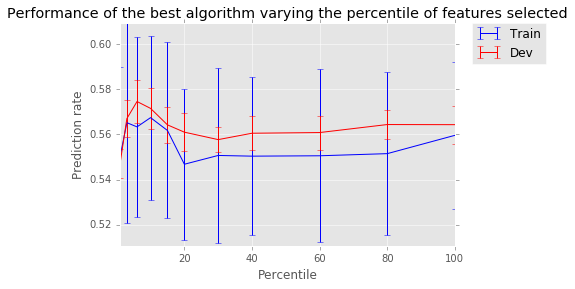

In [104]:
plot_selection(percentiles, score_means, score_stds, score_dev_means, score_dev_stds)

In [63]:
def benchmark_auto_selection(score_func, percentile, train_data, labels, test_data, gold, use_best_params, test_name='dev'):
    """
    Auto select features and apply the ML algorithm, returning the top 4
    """
    #train_sel, test_sel = auto_select_features(score_func, percentile, train_data, labels, test_data, gold)
    ret_sel = pipe.run_multiple_class(train_data, labels, 
                                      test_data, gold, 
                                      use_best_params=use_best_params,
                                      pre_process=[CountVectorizer(tokenizer=tokenize_clean_raw, stop_words=stop_words),
                                                   SelectPercentile(score_func, percentile)]
                                      )
    top = pd.DataFrame(ret_sel[['train score', '{} score'.format(test_name)]].nlargest(3, '{} score'.format(test_name)))
    return top.add_prefix(str(percentile)+' ')

def compare_percentiles(score_func, train_data, labels, test_data, gold, use_best_params, percentiles=[1,3,5,15,30]):
    """
    Given a set of percentiles, calculate the top 4 and concatenate in a comparative table
    """
    def highlight_max(s):
        '''
        highlight the maximum in a Series in bold.
        '''
        is_max = s == s.max()
        css = ['font-weight: bold' if v else '' for v in is_max]
        return css
    
    # get a first df
    df = benchmark_auto_selection(score_func, percentiles[0], train_data, labels, test_data, gold, use_best_params)
    for per in percentiles[1:]:
        tmp = benchmark_auto_selection(score_func, per, train_data, labels, test_data, gold, use_best_params)
        df = pd.concat([df, tmp], axis = 1)

    return df.style.apply(highlight_max)

In [64]:
compare_percentiles(f_classif, 
                    train_tweets, labels, 
                    dev_tweets, dev_labels, 
                    False)

In [107]:
transform = feature_selection.SelectPercentile(feature_selection.mutual_info_classif)
transf = pipe.make_pipeline(CountVectorizer(tokenizer=tokenize_clean_raw,stop_words=stop_words), 
                            transform, 
                            LogisticRegression(random_state=rnd_seed))

percentiles, \
    score_means_mi, score_stds_mi, \
    score_dev_means_mi, score_dev_stds_mi = percentile_search(transf, 
                                                        train_tweets, labels, 
                                                        dev_tweets, dev_labels)

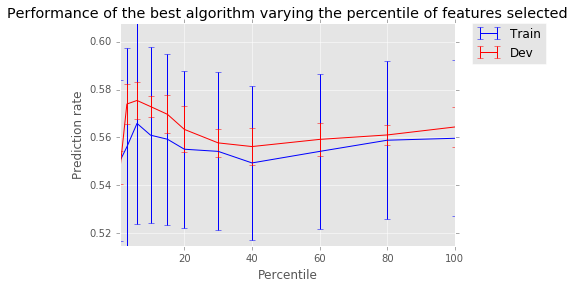

In [108]:
plot_selection(percentiles, score_means_mi, score_stds_mi, score_dev_means_mi, score_dev_stds_mi)

In [65]:
compare_percentiles(mutual_info_classif, 
                    train_tweets, labels, 
                    dev_tweets, dev_labels, 
                    False)

In [110]:
transform = feature_selection.SelectPercentile(feature_selection.chi2)
transf = pipe.make_pipeline(CountVectorizer(tokenizer=tokenize_clean_raw,stop_words=stop_words), 
                            transform, 
                            LogisticRegression(random_state=rnd_seed))

percentiles, \
    score_means_chi, score_stds_chi, \
    score_dev_means_chi, score_dev_stds_chi = percentile_search(transf, 
                                                        train_tweets, labels, 
                                                        dev_tweets, dev_labels)

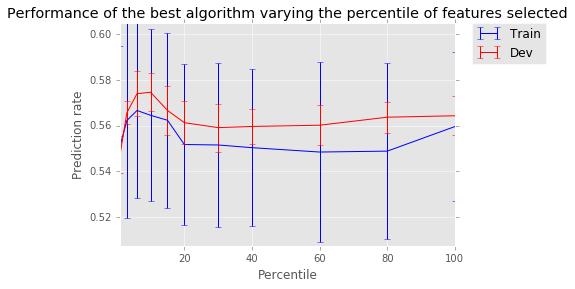

In [111]:
plot_selection(percentiles, score_means_chi, score_stds_chi, score_dev_means_chi, score_dev_stds_chi)

In [66]:
compare_percentiles(chi2, 
                    train_tweets, labels, 
                    dev_tweets, dev_labels, 
                    False)

Now that the dimensions are reduced maybe the XGBoost has a better performance

In [142]:
percentiles = (5, 10, 30, 60, 100)
per_xb = None
train_ark, dev_ark, _ = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=ark.tokenizeRawTweetText, stop_words=stop_words)

for percentile in percentiles:
    train_sel, dev_sel, _ = pipe.auto_select_features(chi2, percentile, \
                                           train_ark, labels, \
                                           dev_ark, dev_labels)

    clf = Pipeline([('to_array', pipe.SparseToArrayTransformer()), ('xgboost', XGBClassifier())])
    r = pipe.train_test_model(clf, train_sel, labels, dev_sel, dev_labels)
    r = pipe.create_scores_df(r, "Xgboost_{}".format(percentile))
    
    if type(per_xb)==pd.DataFrame:
        per_xb = pd.concat([per_xb, r])
    else:
        per_xb = r.copy()

train shape: (8171, 23369)
dev shape: (1405, 23369)
Final shape (8171, 1168) (1405, 1168)
Final shape (8171, 2336) (1405, 2336)
Final shape (8171, 7011) (1405, 7011)
Final shape (8171, 14021) (1405, 14021)
Final shape (8171, 23369) (1405, 23369)


In [143]:
per_xb

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
Xgboost_5,0.441798,0.422140,0.247949,0.693753,0.596330,0.036240,0.008496,0.016862,0.004362,0.006770
Xgboost_10,0.441798,0.422140,0.247949,0.693753,0.596330,0.036240,0.008496,0.016862,0.004362,0.006770
Xgboost_30,0.433810,0.423404,0.250550,0.692930,0.596257,0.039798,0.009209,0.017201,0.004586,0.006039
Xgboost_60,0.435043,0.425389,0.252682,0.692913,0.598095,0.034047,0.008012,0.015747,0.003902,0.005289
Xgboost_100,0.438391,0.423984,0.250287,0.694145,0.597680,0.034143,0.008394,0.015655,0.004047,0.005441


** Conclusion **: The automatic selection works but for some algorithms it makes more difference than others. Different amount of selections for each algorithm also make the difference. And finally, ** Mutual Classification Information** presented the best results. This is the one that is going to be used from now on

### Bigrams and trigrams
As dimentionality reduction showed a decrease in the performance, let's try the opposite direction with bigrams and trigrams

In [67]:
# simple brigram
ret_bigrams = pipe.run_multiple_class(train_tweets, labels, 
                                       dev_tweets, dev_labels, 
                                       rnd_seed=rnd_seed, use_best_params=False, n_jobs=1,
                                       pre_process=[CountVectorizer(tokenizer=tokenize_clean_raw,
                                                   stop_words=stop_words, ngram_range=(1, 2), min_df=1)])
pd.DataFrame(ret_bigrams[['train score', 'dev score']].nlargest(3, 'dev score'))

,train score,dev score
LinearSVC,0.553469,0.544520
RidgeClassifier,0.541987,0.540616
LogisticRegression,0.539079,0.530363


In [68]:
#bigram test with feature selection
train_dataset_bi, dev_dataset_bi, _ = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=tokenize_clean_raw, ngram_range=(1, 2), min_df=1,
                                                           stop_words=stop_words)
train_sel_bi, dev_sel_bi, _ = pipe.auto_select_features(feature_selection.chi2, 2, train_dataset_bi, labels, dev_dataset_bi, dev_labels)
ret_bigrams = pipe.run_multiple_class(train_sel_bi, labels, 
                                      dev_sel_bi, dev_labels, n_jobs=1,
                                      use_best_params=False)
pd.DataFrame(ret_bigrams[['train score', 'dev score']].nlargest(3, 'dev score'))

train shape: (8171, 103150)
dev shape: (1405, 103150)
Final shape (8171, 2063) (1405, 2063)


,train score,dev score
LogisticRegression,0.640495,0.564217
LinearSVC,0.662712,0.563260
SGDClassifier,0.654718,0.550124


In [69]:
# trigram
ret_trigrams = pipe.run_multiple_class(train_tweets, labels, 
                                       dev_tweets, dev_labels, 
                                       rnd_seed=rnd_seed, use_best_params=False, n_jobs=1,
                                       pre_process=[CountVectorizer(tokenizer=tokenize_clean_raw,
                                                   stop_words=stop_words, ngram_range=(1, 3), min_df=1)])
pd.DataFrame(ret_trigrams[['train score', 'dev score']].nlargest(3, 'dev score'))

,train score,dev score
RidgeClassifier,0.530521,0.533108
LinearSVC,0.539787,0.532275
LogisticRegression,0.519653,0.517777


In [70]:
#trigram test with feature selection
train_dataset_tri, test_dataset_tri, _ = pipe.create_count_vec(train_tweets, test_tweets, tokenizer=tokenize_clean_raw, ngram_range=(1, 3), min_df=1)
train_sel, test_sel, _ = pipe.auto_select_features(f_classif, 3, train_dataset_tri, labels, test_dataset_tri, gold)
ret_trigrams = pipe.run_multiple_class(train_sel, labels, test_sel, gold, use_best_params=False, n_jobs=1)
pd.DataFrame(ret_trigrams[['train score', 'dev score']].nlargest(3, 'dev score'))

train shape: (8171, 244480)
dev shape: (3239, 244480)
Final shape (8171, 7334) (3239, 7334)


,train score,dev score
LogisticRegression,0.610207,0.509339
AdaBoostClassifier,0.522312,0.501537
SGDClassifier,0.613103,0.482980


**Conclusion:** the use of bigrams and trigrams did not make the model better so far. Maybe the use of just some brigrams or trigams, like collocations, can bring a better result to the process.

### Optimizing the model
The best results so far have demonstrated 3 different algorithms with similar performance: LogisticRegression(score 0.5234), SGDClassifier(0.5203) and LinearSVC(0.5213). And optimization can be done to check if better performance can be achieved

In [61]:
def optimize_model(cls, params, train_data, labels, test_data, gold, scoring=pipe.scorer):
    """
    Given a model, a Grid Search is done to optimize the model
    """
    # train the model, cross validation of 10
    t0 = time()
    grid_search = GridSearchCV(cls, params, n_jobs=7, verbose=0, scoring=scoring, cv=10)
    grid_search.fit(train_data, labels)
    print("done in %0.3fs" % (time() - t0))
    
    # print the params
    print("Best score: %0.3f" % grid_search.best_score_)
    
    # check the best against the test data
    print("Test score:", scoring(grid_search.best_estimator_, test_data, gold))
    
    return grid_search

def print_params(model):
    from pprint import pprint
    print("Best parameters set:")
    best_parameters = model.best_params_
    pprint(best_parameters)

In [7]:
# recreate the dataset 
transf = pipe.make_pipeline(CountVectorizer(tokenizer=pipe.tokenize_clean_raw, stop_words=pipe.stop_words),
                          SelectPercentile(feature_selection.chi2, percentile=5))
train_sel = transf.fit_transform(train_tweets, labels)
dev_sel = transf.transform(dev_tweets)
test_sel = transf.transform(test_tweets)

In [72]:
dev_sel.shape

(1405, 927)

In [151]:
# first sover
logistic_params = {'C': [.3, .5, 1.0, 100, 1000],
 'class_weight': [None, 'balanced'],
 'dual': [False, True],
 'fit_intercept': [True, False],
 'intercept_scaling': [1],
 'max_iter': [100, 200, 500],
 'multi_class': ['ovr'],
 'penalty': ['l2'],
 'random_state': [rnd_seed],
 'solver': ['liblinear']}

# new solver
logistic_params_new = {'C': [.3, .5, 1.0, 100, 1000],
 'class_weight': [None, 'balanced'],
 'dual': [False],
 'fit_intercept': [True, False],
 'intercept_scaling': [1],
 'max_iter': [50, 100, 200, 500],
 'multi_class': ['ovr', 'multinomial'],
 'penalty': ['l2'],
 'random_state': [rnd_seed],
 'solver': ['newton-cg']}

# other solvers
logistic_params_sag = {'C': [.3, .5, 1.0, 100, 1000],
 'class_weight': [None, 'balanced'],
 'dual': [False],
 'fit_intercept': [True, False],
 'intercept_scaling': [1],
 'max_iter': [100, 200, 500, 5000],
 'multi_class': ['ovr', 'multinomial'],
 'penalty': ['l2'],
 'random_state': [rnd_seed],
 'solver': ['sag', 'lbfgs']}

In [153]:
model = optimize_model(LogisticRegression(), 
                       logistic_params, 
                       train_sel, labels,
                       dev_sel, dev_labels)    

done in 101.551s
Best score: 0.658
('Test score:', 0.60000248723736327)


In [170]:
model = optimize_model(LogisticRegression(), 
                       logistic_params, 
                       train_sel, labels,
                       dev_sel, dev_labels)    

done in 118.191s
Best score: 0.657
('Test score:', 0.61284663316261967)


In [154]:
model1 = optimize_model(LogisticRegression(), logistic_params_new, 
               train_sel, labels,
               dev_sel, dev_labels) 

done in 367.203s
Best score: 0.659
('Test score:', 0.63422330803013116)


In [171]:
model1 = optimize_model(LogisticRegression(), logistic_params_new, 
               train_sel, labels,
               dev_sel, dev_labels) 

done in 397.778s
Best score: 0.659
('Test score:', 0.63642552888128479)


In [172]:
model2 = optimize_model(LogisticRegression(), logistic_params_sag, 
               train_sel, labels,
               dev_sel, dev_labels) 

done in 630.928s
Best score: 0.664
('Test score:', 0.62971516690527951)


In [ ]:
print_params(model2)

In [156]:
linear_params = {'C': [.5, 1.0, 10, 1000],
 'class_weight': [None, 'balanced'],
 'dual': [False, True],
 'fit_intercept': [False, True],
 'intercept_scaling': [1, 10],
 'loss': ['squared_hinge'],
 'max_iter': [1000, 10000],
 'multi_class': ['ovr', 'crammer_singer'],
 'penalty': ['l2'],
 'random_state': [rnd_seed]}

In [189]:
model3 = optimize_model(LinearSVC(), linear_params, 
               train_sel, labels,
               dev_sel, dev_labels) 

done in 10956.772s
Best score: 0.662
('Test score:', 0.62105136097531544)


In [190]:
print_params(model3)

Best parameters set:
{'C': 0.5,
 'class_weight': 'balanced',
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 10,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 9000}


In [173]:
multinomial_params = {'alpha': [.01, 0.1, 1.0, 10.0, 100.0], 
     'fit_prior': [True, False]}

In [174]:
model4 = optimize_model(MultinomialNB(), multinomial_params, 
               train_sel, labels,
               dev_sel, dev_labels) 
print_params(model4)

/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


done in 0.549s
Best score: 0.656
('Test score:', 0.60049546700400591)
Best parameters set:
{'alpha': 0.1, 'fit_prior': True}


In [175]:
SGD_params = {
    'alpha': [0.0001, 0.01, 10],
 'average': [False, True],
 'class_weight': [None, 'balanced'],
 'epsilon': [0.1, 0.001],
#  'eta0': 0.0,
 'fit_intercept': [True, False],
#  'l1_ratio': 0.15,
#  'learning_rate': 'optimal',
 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
 'n_iter': [5, 10, 100],
#  'n_jobs': 1,
#  'penalty': 'l2',
#  'power_t': 0.5,
 'random_state': [rnd_seed],
 'shuffle': [True, False]}
#  'verbose': 0,
#  'warm_start': False}

In [176]:
model5 = optimize_model(SGDClassifier(), SGD_params, 
               train_sel, labels,
               dev_sel, dev_labels) 
print_params(model5)

/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predic

done in 251.424s
Best score: 0.669
('Test score:', 0.61954908950765963)
Best parameters set:
{'alpha': 0.0001,
 'average': True,
 'class_weight': 'balanced',
 'epsilon': 0.1,
 'fit_intercept': True,
 'loss': 'perceptron',
 'n_iter': 100,
 'random_state': 9000,
 'shuffle': True}


In [166]:
scaler = pp.MaxAbsScaler().fit(train_sel)
train_scaled = scaler.transform(train_sel)
dev_scaled = scaler.transform(dev_sel)

model5_scaled = optimize_model(SGDClassifier(), SGD_params, 
               train_scaled, labels,
               dev_scaled, dev_labels) 
print_params(model5_scaled)

/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adrianow/Documents/Programs/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predic

done in 269.087s
Best score: 0.676
('Test score:', 0.62583049748825159)
Best parameters set:
{'alpha': 0.0001,
 'average': True,
 'class_weight': 'balanced',
 'epsilon': 0.1,
 'fit_intercept': True,
 'loss': 'perceptron',
 'n_iter': 100,
 'random_state': 9000,
 'shuffle': True}


The params were inserted inside the pipeline file so that they will be used by the classifiers

In [20]:
reload(pipe)

<module 'libs.pipeline' from 'libs/pipeline.pyc'>

In [21]:
# Final run with best params
final_scores = pipe.run_multiple_class(train_sel, labels,
               dev_sel, dev_labels, use_best_params=True)
pipe.pprint_results(final_scores)

In [32]:
reg_scores = pipe.run_multiple_class(train_sel, labels, test_sel, gold, use_best_params=True, test_name='Test')

In [33]:
pipe.pprint_results(reg_scores, test_name='Test')
#pd.DataFrame(reg_scores[['dev score', 'test score']].nlargest(4, 'dev score'))

In [ ]:
final_scores-reg_scores

The optimization of the parameters was able to improve a little the scores

In [ ]:
clf = pipe.LogisticRegression(**pipe.lr_params)
clf.fit(train_sel, labels)
pred = clf.predict(test_sel)
pipe.score_func(gold, pred)

### Dealing with negation

It will be used the simple negation tatic to find some negation words and then every word after it will be considered negated until a phrase stop is found

In [10]:
def negate_tokens(tw):
    """
    Negate the tokens of the tweets
    """
    new_tokens = []
    neg = False
    for token in tw:
        # check if this words starts the negated process
        if p.negated_token_regex.search(token):
            neg = True
        elif p.end_negated_regex.search(token):
            neg = False
        # check if this token removes the negation process
        elif neg:
            token = 'NEG_'+ token
            
        new_tokens.append(token)
    return new_tokens

def clean_tweet(tw, stop_words):
    """
    Clean list of tokens removing words like mentions, numbers, etc
    """
    tokens = p.normalize_lower(tw)
    tokens = negate_tokens(tokens)
    
    # remove stop words
    tokens = p.remove_stop(tokens, p_stopwords=stop_words) 
    tokens = p.normalize_mentions(tokens)
    tokens = p.normalize_url(tokens)
    tokens = p.normalize_number(tokens) 
    #tokens = p.normalize_hash(tokens)
    
    return tokens

tw = "I never know me: I know something"
clean_tweet(ark.tokenizeRawTweetText(tw), stop_words=p.stop_words)

['never', 'NEG_know', 'NEG_me', ':', 'know', 'something']

In [11]:
# check the negation
train_clean, test_clean, _ = pipe.create_count_vec(train_tweets, test_tweets, tokenizer=pipe.tokenize_negate_clean_raw)
train_data, test_data,_ = pipe.auto_select_features(pipe.mutual_info_classif, 5, train_clean, labels, test_clean, gold)

train shape: (8171, 20116)
dev shape: (3239, 20116)
Final shape (8171, 1005) (3239, 1005)


In [12]:
neg_scores = pipe.run_multiple_class(train_data, labels, test_data, gold, use_best_params=True)
neg_scores

,train score,dev score,f1_dev_neg,f1_dev_neu,f1_dev_pos,train std,dev std,f1_dev_neg std,f1_dev_neu std,f1_dev_pos std
LogisticRegression,0.652707,0.598379,0.507956,0.713998,0.688803,0.038962,0.007105,0.015159,0.003241,0.003771
SGDClassifier,0.655053,0.598999,0.503538,0.731497,0.694460,0.034246,0.005949,0.012065,0.002170,0.004575
LinearSVC,0.656730,0.600054,0.505201,0.726066,0.694908,0.039319,0.008096,0.016555,0.002451,0.002924


In [13]:
pipe.pprint_results(neg_scores)

The Negation brought a small increment on the values

## Brown Clustering
Another set of dimentionality reduction is the brown cluster.

In [9]:
from libs.resources import WordCluster 

wc = WordCluster()

def create_brown(tw, tokenizer=ark.tokenizeRawTweetText, stop_words=pipe.stop_words):
    """
    Gets a clean tweet, tokenize and cleans
    """
    tmp = pipe.tokenize_clean_raw(tw)
    tokens = tmp#[ wc.get_cluster(tok) for tok in tmp if wc.get_cluster(tok)]
    
    return tokens

# check the cluster
train_brown, dev_brown, _ = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=create_brown)
train_brown, dev_brown = pipe.join_lex_features(train_sel, train_brown, dev_sel, dev_brown, create_vec=False)

# train_clean, test_clean, _ = pipe.create_brown(train_tweets, test_tweets, tokenizer=tokenize_negate_clean_cluster_raw)
brown_scores = pipe.run_multiple_class(train_brown, labels, dev_brown, dev_labels, use_best_params=True)


# clst_scores = pipe.run_multiple_class(train_data, labels, test_data, gold, use_best_params=True)
pipe.pprint_results(brown_scores)

train shape: (8171, 18094)
dev shape: (1405, 18094)
train data, lex and final shape:  (8171, 927) (8171, 18094) (8171, 19021)
test data, lex and final shape:  (1405, 927) (1405, 18094) (1405, 19021)


In [10]:
train_brown, dev_brown,_ = pipe.auto_select_features(pipe.chi2, 5, train_brown, labels, dev_brown, dev_labels)
brown_scores = pipe.run_multiple_class(train_brown, labels, dev_brown, dev_labels, use_best_params=True)


# clst_scores = pipe.run_multiple_class(train_data, labels, test_data, gold, use_best_params=True)
pipe.pprint_results(brown_scores)

Final shape (8171, 951) (1405, 951)


In [23]:
reload(pipe)
pipe.pprint_results(pipe.run_multiple_class(train_sel, labels, dev_sel, dev_labels, use_best_params=True))

In [24]:
wc.get_cluster('gas')

'11110101011011'

### Other features creation

Other features may be created in an attempt to make better features

In [25]:
# unescape = HTMLParser().unescape
URL = re.compile('http://[^ ]+')
EXCLAMATION = re.compile('!!+$')
QUESTION = re.compile('\?\?+$')
EXCLQUEST = re.compile('[?!][?!]+$')
#USERNAMES = re.compile('(?<=^|(?<=[^a-zA-Z0-9-\.]))#([A-Za-z_]+[A-Za-z0-9_]+)')
USERNAMES =  re.compile('(@\w+)+')
punctuation = dict([(x,1) for x in '!.?,'])

def genFeatures(text):
#     text = text.lower()
#     newText = unescape(URL.sub('{link}', text).replace('{link}', 'TWEETURL'))
#     newText  = USERNAMES.sub('{uname}', newText).replace('{uname}', '@TWITTERUSERNAME')
    tmp = pipe.tokenize_clean_raw(text)
    
    #bigrams = dict([(tmp[x].lower()+' '+tmp[x+1].lower(), 1) for x in range(len(tmp)-1) if tmp[x] not in punctuation and tmp[x+1] not in punctuation and EXCLQUEST.match(tmp[x]) is None and EXCLQUEST.match(tmp[x+1]) is None])
    #unigrams = dict([(tmp[x].lower(),1) for x in range(len(tmp)) if tmp[x] not in punctuation and EXCLQUEST.match(tmp[x]) is None])
#     bigrams = dict([(tmp[x]+' '+tmp[x+1], 1) for x in range(len(tmp)-1) if EXCLQUEST.match(tmp[x]) is None and EXCLQUEST.match(tmp[x+1]) is None])
#     unigrams = dict([(tmp[x].lower(),1) for x in range(len(tmp)) if EXCLQUEST.match(tmp[x]) is None])
    numCapWords = len([x for x in tmp if x.isupper()])
    numExclamations = len([x for x in tmp if EXCLAMATION.match(x) is not None])
    numQuestions = len([x for x in tmp if QUESTION.match(x) is not None])
    numExclQuest  = len([x for x in tmp if EXCLQUEST.match(x) is not None and '!' in x and '?' in x])
    
    return {"NUMCAPWORDS":numCapWords, "NUMEXCLAMATIONS":numExclamations, "NUMQUESTIONS":numQuestions, "NUMEXCLQUEST":numExclQuest}
    
genFeatures(train_tweets[0])

{'NUMCAPWORDS': 0, 'NUMEXCLAMATIONS': 1, 'NUMEXCLQUEST': 0, 'NUMQUESTIONS': 0}

In [26]:
train_add, dev_add, _ = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=genFeatures)
train_add, dev_add = pipe.join_lex_features(train_sel, train_add, dev_sel, dev_add, create_vec=False)

train shape: (8171, 4)
dev shape: (1405, 4)
train data, lex and final shape:  (8171, 927) (8171, 4) (8171, 931)
test data, lex and final shape:  (1405, 927) (1405, 4) (1405, 931)


In [27]:
add_scores = pipe.run_multiple_class(train_add, labels, dev_add, dev_labels, use_best_params=True)
pipe.pprint_results(add_scores)